In [ ]:
  # Imports

import numpy as np
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt

%matplotlib inline


from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV





from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_csv('/Users/iddobloch/Library/Mobile Documents/com~apple~CloudDocs/Code/Projects/Data Projects/Titanic project /Data/train.csv')
test_df = pd.read_csv('/Users/iddobloch/Library/Mobile Documents/com~apple~CloudDocs/Code/Projects/Data Projects/Titanic project /Data/test.csv')
combine = [train_df, test_df]

Looking at the Data

In [ ]:
print(train_df.columns.values)

In [ ]:
train_df.head()

In [ ]:
train_df.tail()

In [ ]:
train_df.info()
print('_'*40)
test_df.info()

In [ ]:
train_df.describe()

In [ ]:
train_df.describe(include=['O'])

pivot to analyze 

In [ ]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [1]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

NameError: name 'train_df' is not defined

In [ ]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Visualization of the data to look for anymore insights

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [ ]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()


In [ ]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [ ]:
train_df['Ticket'].describe()

for dataset in combine:
    ticket_counts = dataset['Ticket'].value_counts()
    dataset['TicketUnique'] = dataset['Ticket'].map(ticket_counts).apply(lambda x: 0 if x == 1 else 1)
    dataset['Ticket'] = dataset['Ticket'].str.extract('(\d+)').astype(float)


train_df[['TicketUnique', 'Survived']].groupby(['TicketUnique'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
print(len(train_df['Survived']))

In [ ]:
train_df['Deck'] = train_df['Cabin'].str.extract('([A-Za-z])', expand=False)
test_df['Deck'] = test_df['Cabin'].str.extract('([A-Za-z])', expand=False)

# Find passengers without a deck number
missing_deck = train_df['Deck'].isnull()

# Iterate over each passenger without a deck number
for index, row in train_df[missing_deck].iterrows():
    # Find passengers with the same ticket number
    same_ticket = train_df['Ticket'] == row['Ticket']
    same_ticket_with_deck = train_df[same_ticket & ~missing_deck]
    
    # Check if any passenger with the same ticket has a deck number
    if not same_ticket_with_deck.empty:
        # Assign the deck number of the first passenger with the same ticket
        train_df.at[index, 'Deck'] = same_ticket_with_deck.iloc[0]['Deck']
    else:
        # Assign 'N' for passengers without a deck number
        train_df.at[index, 'Deck'] = 'N'

# Repeat the same process for the test dataset
missing_deck = test_df['Deck'].isnull()
for index, row in test_df[missing_deck].iterrows():
    same_ticket = test_df['Ticket'] == row['Ticket']
    same_ticket_with_deck = test_df[same_ticket & ~missing_deck]
    if not same_ticket_with_deck.empty:
        test_df.at[index, 'Deck'] = same_ticket_with_deck.iloc[0]['Deck']
    else:
        test_df.at[index, 'Deck'] = 'N'




In [ ]:
known_deck = train_df[train_df['Deck'].notnull()]
sns.countplot(x='Deck', hue='Pclass', data=known_deck)
plt.xlabel('Deck')
plt.ylabel('Count')
plt.title('Distribution of Passengers by Deck and Pclass')
plt.legend(title='Pclass')
plt.show()


In [ ]:
# Find passengers without a deck in Pclass 3
missing_deck_pclass3 = (train_df['Deck'] == 'N') & (train_df['Pclass'] == 3)

# Find passengers without a deck in Pclass 2
missing_deck_pclass2 = (train_df['Deck'] == 'N') & (train_df['Pclass'] == 2)

# Find passengers without a deck in Pclass 1
missing_deck_pclass1 = (train_df['Deck'] == 'N') & (train_df['Pclass'] == 1)

# Calculate the number of passengers without a deck in each class
num_missing_deck_pclass3 = missing_deck_pclass3.sum()
num_missing_deck_pclass2 = missing_deck_pclass2.sum()
num_missing_deck_pclass1 = missing_deck_pclass1.sum()

# Calculate the number of decks to distribute the passengers without a deck
num_decks_pclass3 = 3
num_decks_pclass2 = 3
num_decks_pclass1 = 5

# Calculate the number of passengers to distribute per deck
num_passengers_per_deck_pclass3 = num_missing_deck_pclass3 // num_decks_pclass3
num_passengers_per_deck_pclass2 = num_missing_deck_pclass2 // num_decks_pclass2
num_passengers_per_deck_pclass1 = num_missing_deck_pclass1 // num_decks_pclass1

# Distribute passengers without a deck in Pclass 3 among decks E, G, F
decks_pclass3 = ['E', 'G', 'F']
for deck in decks_pclass3:
    passengers_to_assign = min(num_passengers_per_deck_pclass3, num_missing_deck_pclass3)
    train_df.loc[missing_deck_pclass3, 'Deck'] = deck
    num_missing_deck_pclass3 -= passengers_to_assign

# Distribute passengers without a deck in Pclass 2 among decks F, E, D
decks_pclass2 = ['F', 'E', 'D']
for deck in decks_pclass2:
    passengers_to_assign = min(num_passengers_per_deck_pclass2, num_missing_deck_pclass2)
    train_df.loc[missing_deck_pclass2, 'Deck'] = deck
    num_missing_deck_pclass2 -= passengers_to_assign

# Distribute passengers without a deck in Pclass 1 among decks A, B, C, D, E
decks_pclass1 = ['A', 'B', 'C', 'D', 'E']
for deck in decks_pclass1:
    passengers_to_assign = min(num_passengers_per_deck_pclass1, num_missing_deck_pclass1)
    train_df.loc[missing_deck_pclass1, 'Deck'] = deck
    num_missing_deck_pclass1 -= passengers_to_assign

    test_df['Deck'] = train_df['Deck']


In [ ]:
for dataset in combine:
    deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    dataset['Deck'] = dataset['Deck'].replace(deck_mapping)

train_df[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived', ascending=False)
test_df.head()

Wrangling the Data - dropping and adding where needed

In [ ]:
train_df = train_df.drop(['Cabin', 'Ticket'], axis=1)
test_df = test_df.drop(['Cabin', 'Ticket'], axis=1)
combine = [train_df, test_df]

train_df.head()


In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [ ]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}  
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

Filling in nulls in the data 

In [ ]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

In [ ]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

In [ ]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [ ]:
guess_ages = np.zeros((2,3))
guess_ages

In [ ]:
print(len(train_df['Survived']))

In [ ]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

In [ ]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [ ]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

In [ ]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

In [ ]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [ ]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

In [ ]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

In [ ]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

In [ ]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

In [ ]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

In [ ]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

In [ ]:
test_df.head(10)

In [406]:
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.svm import SVC, LinearSVC, NuSVC
models = list()


#here is the list of the models we'll try 

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(SVC())
models.append(ExtraTreesClassifier())
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())


# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)


In [407]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

In [408]:
cv_results = []
cv_names = []

for model in models :
        
        cv_results.append(cross_val_score(model, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
        cv_names.append(model.__class__.__name__)

cv_result = pd.DataFrame(cv_results, cv_names)

cv_result["mean"] = cv_result.mean(axis=1)
cv_result["std"] = cv_result.std(axis=1)

cv_result.head(9)


Python(14531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14533) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/iddobloch/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/iddobloch/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/iddobloch/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/

,0,1,2,3,4,mean,std
LogisticRegression,0.787709,0.803371,0.820225,0.780899,0.803371,0.799115,0.013739
DecisionTreeClassifier,0.759777,0.769663,0.820225,0.803371,0.837079,0.798023,0.029373
RandomForestClassifier,0.782123,0.786517,0.831461,0.797753,0.865169,0.812604,0.031460
SVC,0.776536,0.792135,0.814607,0.769663,0.792135,0.789015,0.015522
ExtraTreesClassifier,0.759777,0.780899,0.831461,0.786517,0.865169,0.804764,0.038178
GradientBoostingClassifier,0.782123,0.775281,0.814607,0.803371,0.848315,0.804739,0.025990
AdaBoostClassifier,0.770950,0.780899,0.820225,0.792135,0.842697,0.801381,0.026432
KNeighborsClassifier,0.759777,0.758427,0.814607,0.808989,0.837079,0.795776,0.031388
XGBClassifier,0.765363,0.775281,0.820225,0.803371,0.848315,0.802511,0.030113


In [409]:
cv_res = pd.DataFrame({"CrossValMeans":cv_result['mean'],"CrossValerrors": cv_result['std'],"Algorithm":cv_names})

cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2
cv_res.sort_values(by='criterion', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm,criterion
RandomForestClassifier,0.812604,0.031460,RandomForestClassifier,0.796874
LogisticRegression,0.799115,0.013739,LogisticRegression,0.792246
GradientBoostingClassifier,0.804739,0.025990,GradientBoostingClassifier,0.791744
AdaBoostClassifier,0.801381,0.026432,AdaBoostClassifier,0.788165
XGBClassifier,0.802511,0.030113,XGBClassifier,0.787454
ExtraTreesClassifier,0.804764,0.038178,ExtraTreesClassifier,0.785675
DecisionTreeClassifier,0.798023,0.029373,DecisionTreeClassifier,0.783336
SVC,0.789015,0.015522,SVC,0.781254
KNeighborsClassifier,0.795776,0.031388,KNeighborsClassifier,0.780082


In [ ]:
xgboost = XGBClassifier()

max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 
gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

search_space_XGB = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }

In [ ]:
from sklearn.model_selection import GridSearchCV

GS5 = GridSearchCV(xgboost, search_space_XGB, cv=kfold, scoring="accuracy", n_jobs= 4, verbose=1)
GS5.fit(X_train, Y_train)

In [ ]:
print(GS5.best_params_)
print(GS5.best_score_)
print(GS5.best_estimator_)

In [410]:
# Random Forest hyper parameters tuning

random_forest = RandomForestClassifier(n_estimators=100)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1400, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

search_space_RF = {
    'n_estimators': n_estimators,
    'criterion': ['gini'],
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
}

In [411]:


GS4 = GridSearchCV(
    estimator=random_forest,
    param_grid=search_space_RF, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs= 4
    )


In [412]:
GS4.fit(X_train, Y_train)

Python(14540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [413]:
print("Best Score: ", GS4.best_score_)
print("Best params: ", GS4.best_params_)
print("Best estimator: ", GS4.best_estimator_)

Best Score:  0.8182097796748478
Best params:  {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
Best estimator:  RandomForestClassifier(criterion='entropy')


In [ ]:
LR = LogisticRegression()

search_space_LR = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(0, 4, 10)
}

In [ ]:
GS3 = GridSearchCV(
    estimator=LR,
    param_grid=search_space_LR, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs=-1
    )
GS3.fit(X_train, Y_train)

In [ ]:
print("Best Score: ", GS3.best_score_)
print("Best params: ", GS3.best_params_)
print("Best estimator: ", GS3.best_estimator_)

In [ ]:
gradient_boosting = GradientBoostingClassifier(n_estimators=100)


learning_rates = [1, 0.25, 0.1, 0.05, 0.01]
#the number of trees in the forest
n_estimators = [1, 2, 4,  32, 100, 150, 200,  300]
# how deep the built tree can be
max_depths = np.linspace(1, 32, 8, endpoint=True)

#minimum number of samples required to be at a leaf node.
min_samples_leafs =  np.linspace(0.1, 0.5, 4, endpoint=True)
#represents the number of features to consider when looking for the best split
max_features = [0.5, 0.3, 0.1]

search_space_GB = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': max_depths,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leafs
}

In [ ]:
GS1 = GridSearchCV(
    estimator=gradient_boosting,
    param_grid=search_space_GB, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs=4
    )
GS1.fit(X_train, Y_train)

In [ ]:
print("Best Score: ", GS1.best_score_)
print("Best params: ", GS1.best_params_)
print("Best estimator: ", GS1.best_estimator_)

In [ ]:
extra_trees = ExtraTreesClassifier(n_estimators=100)

search_space_ET = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini'],
    'bootstrap': [True, False]
}

In [ ]:
GS0 = GridSearchCV(
    estimator=extra_trees,
    param_grid=search_space_ET, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs= 4
    )
GS0.fit(X_train, Y_train)

In [ ]:
print("Best Score: ", GS0.best_score_)
print("Best params: ", GS0.best_params_)
print("Best estimator: ", GS0.best_estimator_)

In [ ]:
k_neighbors = KNeighborsClassifier()

search_space_KN = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [ ]:
GS2 = GridSearchCV(
    estimator=k_neighbors,
    param_grid=search_space_KN, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs= 4
    )
GS2.fit(X_train, Y_train)

In [ ]:
print("Best Score: ", GS2.best_score_)
print("Best params: ", GS2.best_params_)
print("Best estimator: ", GS2.best_estimator_)


In [399]:
lightgbm = lgb.LGBMClassifier()

search_space_lgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 7, 9]
}

In [400]:
GS6 = GridSearchCV(
    estimator=lightgbm,
    param_grid=search_space_lgb, 
    cv=kfold, 
    scoring= 'accuracy', 
    n_jobs= 4
    )
GS6.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Info] Number of positive: 308, number of negative: 494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 802, number of used features: 10
[LightGBM] [

KeyboardInterrupt: 

In [ ]:
print("Best Score: ", GS6.best_score_)
print("Best params: ", GS6.best_params_)
print("Best estimator: ", GS6.best_estimator_)

In [ ]:
print(len(train_df['Survived']))
print(len(X_train))

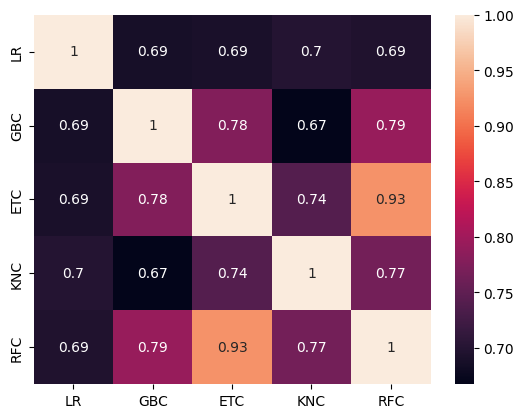

In [414]:
test_Survived_LR = pd.Series(GS3.best_estimator_.predict(X_test), name="LR")
test_Survived_RFC = pd.Series(GS4.best_estimator_.predict(X_test), name="RFC")
test_Survived_GBC = pd.Series(GS1.best_estimator_.predict(X_test), name="GBC")
test_Survived_ETC = pd.Series(GS0.best_estimator_.predict(X_test), name="ETC")
test_Survived_KNC = pd.Series(GS2.best_estimator_.predict(X_test), name="KNC")
test_Survived_XGB = pd.Series(GS5.best_estimator_.predict(X_test), name="XGB")
test_Survived_LGB = pd.Series(GS6.best_estimator_.predict(X_test), name="LGB")

ensemble_results = pd.concat([test_Survived_LR,test_Survived_GBC,test_Survived_ETC, test_Survived_KNC, test_Survived_RFC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)


In [415]:
print('test score LR:', GS3.best_score_)
print('test score RFC:', GS4.best_score_)
print('test score GBC:', GS1.best_score_)
print('test score ETC:', GS0.best_score_)
print('test score KNC:', GS2.best_score_)
print('test score XGB:', GS5.best_score_)
print('test score LGB:', GS6.best_score_)


test score LR: 0.8046941323345818
test score RFC: 0.8182097796748478
test score GBC: 0.8249812734082397
test score ETC: 0.8171285892634208
test score KNC: 0.8137203495630461


In [ ]:
print(len(X_train))
print(len(Y_train))

In [417]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('LR', GS3.best_estimator_), 
('GBC', GS1.best_estimator_), ('ETC', GS0.best_estimator_), ('KNC', GS2.best_estimator_), ("RandomForest",GS4.best_estimator_), ('XBG', GS5.best_estimator_)], voting='hard', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)
votingC.score(X_train, Y_train)

0.8810325476992144

In [403]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")

In [404]:
output = pd.concat([test_df['PassengerId'], test_Survived], axis=1)
output.to_csv('submission1.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [424]:
from sklearn.ensemble import StackingClassifier

estimators = [('RF', RandomForestClassifier()),
              ('ETC', ExtraTreesClassifier()),
                ('GBC', GradientBoostingClassifier()),
                ('KNC', KNeighborsClassifier()),
                ('LR', LogisticRegression()),
                ('XGB', XGBClassifier())
             ]

stackingC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

stackingC = stackingC.fit(X_train, Y_train)
stackingC.score(X_train, Y_train)



0.8630751964085297